In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import os
import json
import sys
import numpy as np
sys.path.append("..")
import copy

In [3]:
from src import models, data, operators, utils, functional, metrics, lens
from src.utils import logging_utils
import logging
import torch
import baukit

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.INFO,
    format = logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout
)

In [4]:
mt = models.load_model(name = "gptj", fp16 = True, device = "cuda")

2023-06-13 23:24:28 src.models INFO     loading EleutherAI/gpt-j-6B (device=cuda, fp16=True)


In [113]:
relation = data.load_dataset().filter(relation_names=["country capital city"])[0].set(prompt_templates=[" {}:"])
train, test = relation.split(5)

In [114]:
icl_prompt = functional.make_prompt(
    prompt_template = train.prompt_templates[0],
    subject = "{}",
    examples = train.samples,
    mt = mt
)
print(icl_prompt)

<|endoftext|> South Korea: Seoul
 China: Beijing
 Italy: Rome
 Russia: Moscow
 France: Paris
 {}:


In [115]:
test = functional.filter_relation_samples_based_on_provided_fewshots(
    mt = mt, 
    test_relation=test,
    prompt_template = icl_prompt,
    batch_size=4
)
len(test.samples)

14

### Current Method => Calculate $b_r$ and $W_r$ individually and average them.

In [118]:
estimator = operators.JacobianIclMeanEstimator(
    mt = mt, h_layer=7, beta=0.2
)
operator = estimator(train)

South Korea -> Seoul | z_norm=244.5 | z_proj=24.53125 || o_pred=([(' inter', 0.083), (' San', 0.029), (' Alaska', 0.027)], {})
China -> Beijing | z_norm=265.0 | z_proj=21.328125 || o_pred=([(' Washington', 0.815), ('Washington', 0.028), (' Moscow', 0.012)], {})
Italy -> Rome | z_norm=262.0 | z_proj=20.890625 || o_pred=([(' Madrid', 0.188), (' Moscow', 0.139), (' Paris', 0.089)], {})
Russia -> Moscow | z_norm=250.75 | z_proj=22.703125 || o_pred=([(' Taiwanese', 0.283), (' Taiwan', 0.139), (' Hungary', 0.076)], {})
France -> Paris | z_norm=261.25 | z_proj=19.3125 || o_pred=([(' Bon', 0.16), (' Rome', 0.033), (' Jerusalem', 0.016)], {})

projection with mean weight
South Korea -> Seoul | z_norm=244.5 | z_proj=35.84375 || o_pred=([(' Seoul', 0.999), (' Korean', 0.001), (' Korea', 0.0)], {})
China -> Beijing | z_norm=265.0 | z_proj=38.65625 || o_pred=([(' Chinese', 0.487), (' Shanghai', 0.176), (' Beijing', 0.158)], {})
Italy -> Rome | z_norm=262.0 | z_proj=35.46875 || o_pred=([(' Italy', 0

In [119]:
# calculate faithfulness
def evaluate_operator(operator, test_samples):
    pred_objects = []
    test_objects = []
    for sample in test_samples:
        test_objects.append(sample.object)
        preds = operator(sample.subject, k=3)
        pred = str(preds.predictions[0])
        print(f"{sample.subject=} -> {sample.object=} | {pred=}")
        pred_objects.append([p.token for p in preds.predictions])

    recall = metrics.recall(pred_objects, test_objects)
    return recall

evaluate_operator(operator, test.samples)

sample.subject='Argentina' -> sample.object='Buenos Aires' | pred=' Buenos (p=0.956)'
sample.subject='Chile' -> sample.object='Santiago' | pred=' Santiago (p=0.637)'
sample.subject='Colombia' -> sample.object='Bogot\\u00e1' | pred=' Bog (p=0.736)'
sample.subject='Egypt' -> sample.object='Cairo' | pred=' Cairo (p=0.970)'
sample.subject='Germany' -> sample.object='Berlin' | pred=' Berlin (p=0.958)'
sample.subject='India' -> sample.object='New Delhi' | pred=' Delhi (p=0.574)'
sample.subject='Japan' -> sample.object='Tokyo' | pred=' Tokyo (p=0.986)'
sample.subject='Mexico' -> sample.object='Mexico City' | pred=' Mexico (p=0.990)'
sample.subject='Pakistan' -> sample.object='Islamabad' | pred=' Islamabad (p=0.558)'
sample.subject='Peru' -> sample.object='Lima' | pred=' Lima (p=0.923)'
sample.subject='Saudi Arabia' -> sample.object='Riyadh' | pred=' Riyadh (p=0.233)'
sample.subject='Spain' -> sample.object='Madrid' | pred=' Madrid (p=0.784)'
sample.subject='United States' -> sample.object='Wa

[0.9285714285714286, 0.9285714285714286, 0.9285714285714286]

In [120]:
lens.logit_lens(mt = mt, h = operator.bias, get_proba=True, k = 10)

([(' Paris', 0.174),
  (' ', 0.126),
  ('\n', 0.068),
  (' London', 0.057),
  (' Beijing', 0.051),
  (' New', 0.025),
  (' Rome', 0.025),
  (' Moscow', 0.024),
  (' P', 0.018),
  (' B', 0.015)],
 {})

### Get rid of the $\beta$ by setting $\beta = 1$

In [121]:
# operator_dct = deepcopy(operator.__dict__)
operator_dct = operator.__dict__.copy()
operator_dct["beta"] = None
operator_no_beta = operators.LinearRelationOperator(**operator_dct)

evaluate_operator(operator_no_beta, test.samples)

sample.subject='Argentina' -> sample.object='Buenos Aires' | pred='  (p=0.162)'
sample.subject='Chile' -> sample.object='Santiago' | pred='  (p=0.208)'
sample.subject='Colombia' -> sample.object='Bogot\\u00e1' | pred='  (p=0.197)'
sample.subject='Egypt' -> sample.object='Cairo' | pred='  (p=0.162)'
sample.subject='Germany' -> sample.object='Berlin' | pred=' Berlin (p=0.312)'
sample.subject='India' -> sample.object='New Delhi' | pred=' New (p=0.155)'
sample.subject='Japan' -> sample.object='Tokyo' | pred=' Tokyo (p=0.550)'
sample.subject='Mexico' -> sample.object='Mexico City' | pred='  (p=0.152)'
sample.subject='Pakistan' -> sample.object='Islamabad' | pred=' Beijing (p=0.148)'
sample.subject='Peru' -> sample.object='Lima' | pred='  (p=0.166)'
sample.subject='Saudi Arabia' -> sample.object='Riyadh' | pred='  (p=0.202)'
sample.subject='Spain' -> sample.object='Madrid' | pred='  (p=0.151)'
sample.subject='United States' -> sample.object='Washington D.C.' | pred=' New (p=0.130)'
sample.su

[0.21428571428571427, 0.21428571428571427, 0.2857142857142857]

In [122]:
hs_and_zs = functional.compute_hs_and_zs(
    mt = mt,
    prompt_template = train.prompt_templates[0],
    subjects = [sample.subject for sample in relation.samples],
    h_layer= operator.h_layer,
    z_layer=-1,
    batch_size=4,
    examples= train.samples
)

In [123]:
for sample in train.samples:
    subj = sample.subject
    obj = sample.object
    pred = functional.predict_next_token(
        mt = mt,
        prompt = functional.make_prompt(
            prompt_template = train.prompt_templates[0],
            subject = subj,
            examples = train.samples,
            mt = mt
        )
    )[0][0]
    h_norm = hs_and_zs.h_by_subj[subj].norm().item()
    z_norm = hs_and_zs.z_by_subj[subj].norm().item()
    print(f"{subj=} -> {obj=} | {h_norm=} | {z_norm=} || {pred=}")

subj='South Korea' -> obj='Seoul' | h_norm=69.6875 | z_norm=244.625 || pred=PredictedToken(token=' Seoul', prob=0.9904340505599976)
subj='China' -> obj='Beijing' | h_norm=71.3125 | z_norm=265.0 || pred=PredictedToken(token=' Beijing', prob=0.9328234791755676)
subj='Italy' -> obj='Rome' | h_norm=70.875 | z_norm=262.0 || pred=PredictedToken(token=' Rome', prob=0.8342717885971069)
subj='Russia' -> obj='Moscow' | h_norm=69.875 | z_norm=250.625 || pred=PredictedToken(token=' Moscow', prob=0.936684250831604)
subj='France' -> obj='Paris' | h_norm=71.75 | z_norm=261.0 || pred=PredictedToken(token=' Paris', prob=0.9446226358413696)


### $b_r = \mathbf{o}_{mean} - J\mathbf{s}_{mean}$

In [124]:
z_mean = torch.stack([hs_and_zs.z_by_subj[sample.subject] for sample in train.samples]).mean(dim = 0)
h_mean = torch.stack([hs_and_zs.h_by_subj[sample.subject] for sample in train.samples]).mean(dim = 0)

bias_mean = z_mean - operator.weight @ h_mean
print(torch.dist(bias_mean, operator.bias))

tensor(19.5469, device='cuda:0', dtype=torch.float16, grad_fn=<DistBackward0>)


In [125]:
operator_dct = operator.__dict__.copy()
operator_dct["beta"] = 1 #.2
operator_dct["bias"] = bias_mean
operator_bias_J = operators.LinearRelationOperator(**operator_dct)

evaluate_operator(operator_bias_J, test.samples)

sample.subject='Argentina' -> sample.object='Buenos Aires' | pred='  (p=0.129)'
sample.subject='Chile' -> sample.object='Santiago' | pred='  (p=0.174)'
sample.subject='Colombia' -> sample.object='Bogot\\u00e1' | pred=' Paris (p=0.170)'
sample.subject='Egypt' -> sample.object='Cairo' | pred='\n (p=0.134)'
sample.subject='Germany' -> sample.object='Berlin' | pred=' Berlin (p=0.378)'
sample.subject='India' -> sample.object='New Delhi' | pred=' New (p=0.200)'
sample.subject='Japan' -> sample.object='Tokyo' | pred=' Tokyo (p=0.456)'
sample.subject='Mexico' -> sample.object='Mexico City' | pred=' Paris (p=0.156)'
sample.subject='Pakistan' -> sample.object='Islamabad' | pred='  (p=0.098)'
sample.subject='Peru' -> sample.object='Lima' | pred='  (p=0.137)'
sample.subject='Saudi Arabia' -> sample.object='Riyadh' | pred='  (p=0.163)'
sample.subject='Spain' -> sample.object='Madrid' | pred=' Paris (p=0.196)'
sample.subject='United States' -> sample.object='Washington D.C.' | pred=' New (p=0.159)'


[0.21428571428571427, 0.35714285714285715, 0.35714285714285715]

### $b_r = F(\mathbf{s}_{mean}) -J\mathbf{s}_{mean}$

In [126]:
h_layer_name, z_layer_name = models.determine_layer_paths(mt, layers = [operator.h_layer, operator.z_layer])

In [127]:
hs_and_zs.h_by_subj.keys()

dict_keys(['United States', 'Canada', 'Mexico', 'Brazil', 'Argentina', 'Chile', 'Peru', 'Colombia', 'Venezuela', 'Spain', 'France', 'Germany', 'Italy', 'Russia', 'China', 'Japan', 'South Korea', 'India', 'Pakistan', 'Nigeria', 'Egypt', 'Saudi Arabia', 'Turkey', 'Australia'])

In [128]:
def get_intervention(h, int_layer, subj_idx):
    def edit_output(output, layer):
        if(layer != int_layer):
            return output
        functional.untuple(output)[:, subj_idx] = h
        return output
    return edit_output

subject = "Russia"
prompt = icl_prompt.format(subject)

h_index, inputs = functional.find_subject_token_index(
    mt=mt,
    prompt=prompt,
    subject=subject,
)

with baukit.TraceDict(
    mt.model, layers = [h_layer_name, z_layer_name],
    edit_output=get_intervention(h_mean, h_layer_name, h_index)
) as traces:
    outputs = mt.model(
        input_ids = inputs.input_ids,
        attention_mask = inputs.attention_mask,
    )

lens.interpret_logits(
    mt = mt, 
    logits = outputs.logits[0][-1], 
    get_proba=True
)

[(' Beijing', 0.665),
 (' Shanghai', 0.131),
 (' Tokyo', 0.065),
 (' Seoul', 0.035),
 (' Hong', 0.015),
 (' P', 0.007),
 (' Paris', 0.006),
 (' Xi', 0.005),
 (' Guang', 0.004),
 (' Tai', 0.003)]

In [129]:
s = functional.untuple(traces[h_layer_name].output)[0][h_index]
s.shape

torch.Size([4096])

In [130]:
z_mean_F = traces[z_layer_name].output[0][-1][-1]
# lens.logit_lens(mt = mt, h = z_mean_F, get_proba=True)
bias_F = z_mean_F - operator.weight @ h_mean
print(torch.dist(bias_F, operator.bias))
lens.logit_lens(mt = mt, h = bias_F, get_proba=True)

tensor(71.5625, device='cuda:0', dtype=torch.float16, grad_fn=<DistBackward0>)


([(' Beijing', 0.627),
  (' Shanghai', 0.116),
  (' Tokyo', 0.051),
  (' Seoul', 0.027),
  (' Hong', 0.024),
  (' Paris', 0.015),
  (' Guang', 0.01),
  (' Nan', 0.009),
  (' P', 0.009),
  (' Xi', 0.007)],
 {})

In [131]:
operator_dct = operator.__dict__.copy()
operator_dct["beta"] = 1 #.2
operator_dct["bias"] = bias_F
operator_bias_J = operators.LinearRelationOperator(**operator_dct)

evaluate_operator(operator_bias_J, test.samples)

sample.subject='Argentina' -> sample.object='Buenos Aires' | pred=' Beijing (p=0.687)'
sample.subject='Chile' -> sample.object='Santiago' | pred=' Beijing (p=0.712)'
sample.subject='Colombia' -> sample.object='Bogot\\u00e1' | pred=' Beijing (p=0.531)'
sample.subject='Egypt' -> sample.object='Cairo' | pred=' Beijing (p=0.725)'
sample.subject='Germany' -> sample.object='Berlin' | pred=' Beijing (p=0.528)'
sample.subject='India' -> sample.object='New Delhi' | pred=' Beijing (p=0.600)'
sample.subject='Japan' -> sample.object='Tokyo' | pred=' Tokyo (p=0.790)'
sample.subject='Mexico' -> sample.object='Mexico City' | pred=' Beijing (p=0.710)'
sample.subject='Pakistan' -> sample.object='Islamabad' | pred=' Beijing (p=0.729)'
sample.subject='Peru' -> sample.object='Lima' | pred=' Beijing (p=0.648)'
sample.subject='Saudi Arabia' -> sample.object='Riyadh' | pred=' Beijing (p=0.644)'
sample.subject='Spain' -> sample.object='Madrid' | pred=' Beijing (p=0.547)'
sample.subject='United States' -> samp

[0.07142857142857142, 0.07142857142857142, 0.07142857142857142]

### Make all the $|\mathbf{o}|$ similar

In [132]:
z_s = torch.stack([hs_and_zs.z_by_subj[sample.subject] for sample in train.samples])
min_norm = z_s.norm(dim = 1).min()
z_s = torch.stack([(z*min_norm)/z.norm() for z in z_s])

z_mean = z_s.mean(dim = 0)
bias_mean = z_mean - operator.weight @ h_mean

print(torch.dist(bias_mean, operator.bias))
lens.logit_lens(mt = mt, h = bias_mean, get_proba=True)

tensor(22.9219, device='cuda:0', dtype=torch.float16, grad_fn=<DistBackward0>)


([(' Paris', 0.243),
  (' ', 0.089),
  (' London', 0.071),
  ('\n', 0.053),
  (' New', 0.031),
  (' Beijing', 0.025),
  (' Moscow', 0.024),
  (' Brussels', 0.022),
  (' Rome', 0.022),
  (' T', 0.016)],
 {})

In [133]:
operator_dct = operator.__dict__.copy()
operator_dct["beta"] = 1 #.2
operator_dct["bias"] = bias_mean
operator_similar_o = operators.LinearRelationOperator(**operator_dct)

evaluate_operator(operator_similar_o, test.samples)

sample.subject='Argentina' -> sample.object='Buenos Aires' | pred='  (p=0.129)'
sample.subject='Chile' -> sample.object='Santiago' | pred='  (p=0.177)'
sample.subject='Colombia' -> sample.object='Bogot\\u00e1' | pred=' Paris (p=0.164)'
sample.subject='Egypt' -> sample.object='Cairo' | pred='\n (p=0.138)'
sample.subject='Germany' -> sample.object='Berlin' | pred=' Berlin (p=0.427)'
sample.subject='India' -> sample.object='New Delhi' | pred=' New (p=0.216)'
sample.subject='Japan' -> sample.object='Tokyo' | pred=' Tokyo (p=0.507)'
sample.subject='Mexico' -> sample.object='Mexico City' | pred=' Paris (p=0.150)'
sample.subject='Pakistan' -> sample.object='Islamabad' | pred='  (p=0.096)'
sample.subject='Peru' -> sample.object='Lima' | pred='  (p=0.136)'
sample.subject='Saudi Arabia' -> sample.object='Riyadh' | pred='  (p=0.165)'
sample.subject='Spain' -> sample.object='Madrid' | pred=' Paris (p=0.188)'
sample.subject='United States' -> sample.object='Washington D.C.' | pred=' New (p=0.169)'


[0.21428571428571427, 0.35714285714285715, 0.35714285714285715]

### Automatically *tune* $\beta$ for each training sample 

In [134]:
training_hs = torch.stack([hs_and_zs.h_by_subj[sample.subject] for sample in train.samples])
training_zs = torch.stack([hs_and_zs.z_by_subj[sample.subject] for sample in train.samples])

biases = []
for sample in train.samples:
    subj = sample.subject
    obj = sample.object
    h = hs_and_zs.h_by_subj[subj]
    z = hs_and_zs.z_by_subj[subj]
    b_sample = z - operator.weight @ h
    print(f"{subj=} | h_norm={h.norm()} | z_norm={z.norm()} || b_norm={b_sample.norm()}")
    for beta in np.linspace(0, 1, 10):
        z_est = operator.weight @ h + b_sample * beta
        pred, _ = lens.logit_lens(mt = mt, h = z_est, get_proba=True, k = 3)
        print(f"{obj=} | {beta=} | z_est={z_est.norm()} | {pred=}")
        top_token = pred[0][0]
        if functional.is_nontrivial_prefix(prediction=top_token, target=sample.object):
            biases.append(b_sample * beta)
            break
    print()

subj='South Korea' | h_norm=69.6875 | z_norm=244.625 || b_norm=239.125
obj='Seoul' | beta=0.0 | z_est=35.84375 | pred=[(' Seoul', 0.999), (' Korean', 0.001), (' Korea', 0.0)]

subj='China' | h_norm=71.3125 | z_norm=265.0 || b_norm=251.0
obj='Beijing' | beta=0.0 | z_est=38.65625 | pred=[(' Chinese', 0.489), (' Shanghai', 0.177), (' Beijing', 0.156)]
obj='Beijing' | beta=0.1111111111111111 | z_est=53.9375 | pred=[(' Beijing', 0.837), (' Shanghai', 0.135), (' Chinese', 0.013)]

subj='Italy' | h_norm=70.875 | z_norm=262.0 || b_norm=251.75
obj='Rome' | beta=0.0 | z_est=35.46875 | pred=[(' Italy', 0.591), (' Rome', 0.195), (' Italian', 0.091)]
obj='Rome' | beta=0.1111111111111111 | z_est=49.8125 | pred=[(' Rome', 0.866), (' Milan', 0.075), (' Italy', 0.05)]

subj='Russia' | h_norm=69.875 | z_norm=250.625 || b_norm=244.75
obj='Moscow' | beta=0.0 | z_est=33.1875 | pred=[(' Moscow', 0.619), (' Russian', 0.08), (' Russians', 0.064)]

subj='France' | h_norm=71.75 | z_norm=261.0 || b_norm=258.75
o

In [135]:
operator = estimator(train)

South Korea -> Seoul | z_norm=244.5 | z_proj=24.53125 || o_pred=([(' inter', 0.083), (' San', 0.029), (' Alaska', 0.027)], {})
China -> Beijing | z_norm=265.0 | z_proj=21.328125 || o_pred=([(' Washington', 0.815), ('Washington', 0.028), (' Moscow', 0.012)], {})
Italy -> Rome | z_norm=262.0 | z_proj=20.890625 || o_pred=([(' Madrid', 0.188), (' Moscow', 0.139), (' Paris', 0.089)], {})
Russia -> Moscow | z_norm=250.75 | z_proj=22.703125 || o_pred=([(' Taiwanese', 0.283), (' Taiwan', 0.139), (' Hungary', 0.076)], {})
France -> Paris | z_norm=261.25 | z_proj=19.3125 || o_pred=([(' Bon', 0.16), (' Rome', 0.033), (' Jerusalem', 0.016)], {})

projection with mean weight
South Korea -> Seoul | z_norm=244.5 | z_proj=35.84375 || o_pred=([(' Seoul', 0.999), (' Korean', 0.001), (' Korea', 0.0)], {})
China -> Beijing | z_norm=265.0 | z_proj=38.65625 || o_pred=([(' Chinese', 0.487), (' Shanghai', 0.176), (' Beijing', 0.158)], {})
Italy -> Rome | z_norm=262.0 | z_proj=35.46875 || o_pred=([(' Italy', 0

In [136]:
biases = []
for sample, approx in zip(train.samples, operator.metadata["approxes"]):
    subj = sample.subject
    obj = sample.object
    h = approx.h
    z = approx.z
    print(f"{subj=} | h_norm={h.norm()} | z_norm={z.norm()} || b_norm={approx.bias.norm()}")
    for beta in np.linspace(0, 1, 10):
        z_est = approx.weight @ h + approx.bias * beta
        pred, _ = lens.logit_lens(mt = mt, h = z_est, get_proba=True, k = 3)
        print(f"{obj=} | {beta=} | z_est={z_est.norm()} | {pred=}")
        top_token = pred[0][0]
        if functional.is_nontrivial_prefix(prediction=top_token, target=sample.object):
            biases.append(b_sample * beta)
            break
    print()

subj='South Korea' | h_norm=69.6875 | z_norm=244.5 || b_norm=242.375
obj='Seoul' | beta=0.0 | z_est=24.53125 | pred=[(' inter', 0.083), (' San', 0.029), (' Alaska', 0.027)]
obj='Seoul' | beta=0.1111111111111111 | z_est=37.09375 | pred=[(' Seoul', 0.843), (' Tokyo', 0.039), (' Los', 0.015)]

subj='China' | h_norm=71.3125 | z_norm=265.0 || b_norm=261.25
obj='Beijing' | beta=0.0 | z_est=21.328125 | pred=[(' Washington', 0.815), ('Washington', 0.028), (' Moscow', 0.012)]
obj='Beijing' | beta=0.1111111111111111 | z_est=38.3125 | pred=[(' Beijing', 0.925), (' Shanghai', 0.016), (' Washington', 0.015)]

subj='Italy' | h_norm=70.875 | z_norm=262.0 || b_norm=259.0
obj='Rome' | beta=0.0 | z_est=20.890625 | pred=[(' Madrid', 0.187), (' Moscow', 0.138), (' Paris', 0.088)]
obj='Rome' | beta=0.1111111111111111 | z_est=37.34375 | pred=[(' Rome', 0.863), (' Madrid', 0.024), (' London', 0.023)]

subj='Russia' | h_norm=69.875 | z_norm=250.75 || b_norm=249.75
obj='Moscow' | beta=0.0 | z_est=22.703125 | p

In [137]:
b_mean = torch.stack(biases).mean(dim = 0)

operator_dct = operator.__dict__.copy()
operator_dct["beta"] = 1 #.2
operator_dct["bias"] = b_mean
operator_auto_beta = operators.LinearRelationOperator(**operator_dct)

evaluate_operator(operator_auto_beta, test.samples)

sample.subject='Argentina' -> sample.object='Buenos Aires' | pred=' Buenos (p=0.802)'
sample.subject='Chile' -> sample.object='Santiago' | pred=' Santiago (p=0.547)'
sample.subject='Colombia' -> sample.object='Bogot\\u00e1' | pred=' Colombia (p=0.397)'
sample.subject='Egypt' -> sample.object='Cairo' | pred=' Cairo (p=0.946)'
sample.subject='Germany' -> sample.object='Berlin' | pred=' Berlin (p=0.898)'
sample.subject='India' -> sample.object='New Delhi' | pred=' India (p=0.560)'
sample.subject='Japan' -> sample.object='Tokyo' | pred=' Tokyo (p=0.981)'
sample.subject='Mexico' -> sample.object='Mexico City' | pred=' Mexico (p=0.983)'
sample.subject='Pakistan' -> sample.object='Islamabad' | pred=' Pakistan (p=0.488)'
sample.subject='Peru' -> sample.object='Lima' | pred=' Lima (p=0.838)'
sample.subject='Saudi Arabia' -> sample.object='Riyadh' | pred=' Riyadh (p=0.506)'
sample.subject='Spain' -> sample.object='Madrid' | pred=' Madrid (p=0.676)'
sample.subject='United States' -> sample.object

[0.7142857142857143, 0.9285714285714286, 0.9285714285714286]

### Drop $J\mathbf{s}$ entirely from bias estimation. (basically the corner method?)

In [138]:
biases = torch.stack([approx.bias[0] for approx in operator.metadata["approxes"]])
min_norm = biases.norm(dim = 1).min()

biases = torch.stack([(b*min_norm)/b.norm() for b in biases])
b_mean = biases.mean(dim = 0)

print(torch.dist(b_mean, operator.bias))
lens.logit_lens(mt = mt, h = b_mean, get_proba=True)

tensor(10.5078, device='cuda:0', dtype=torch.float16, grad_fn=<DistBackward0>)


([(' Paris', 0.172),
  (' ', 0.128),
  ('\n', 0.068),
  (' London', 0.058),
  (' Beijing', 0.049),
  (' New', 0.026),
  (' Moscow', 0.025),
  (' Rome', 0.024),
  (' P', 0.018),
  (' Seoul', 0.015)],
 {})

In [139]:
b_mean.norm().item(), operator.bias.norm().item()

(222.25, 232.75)

In [140]:
operator_dct = operator.__dict__.copy()
operator_dct["beta"] = .2 #.2
operator_dct["bias"] = b_mean
operator_dropped_js = operators.LinearRelationOperator(**operator_dct)

evaluate_operator(operator_dropped_js, test.samples)

sample.subject='Argentina' -> sample.object='Buenos Aires' | pred=' Buenos (p=0.953)'
sample.subject='Chile' -> sample.object='Santiago' | pred=' Santiago (p=0.637)'
sample.subject='Colombia' -> sample.object='Bogot\\u00e1' | pred=' Bog (p=0.743)'
sample.subject='Egypt' -> sample.object='Cairo' | pred=' Cairo (p=0.969)'
sample.subject='Germany' -> sample.object='Berlin' | pred=' Berlin (p=0.956)'
sample.subject='India' -> sample.object='New Delhi' | pred=' Delhi (p=0.567)'
sample.subject='Japan' -> sample.object='Tokyo' | pred=' Tokyo (p=0.986)'
sample.subject='Mexico' -> sample.object='Mexico City' | pred=' Mexico (p=0.991)'
sample.subject='Pakistan' -> sample.object='Islamabad' | pred=' Islamabad (p=0.549)'
sample.subject='Peru' -> sample.object='Lima' | pred=' Lima (p=0.928)'
sample.subject='Saudi Arabia' -> sample.object='Riyadh' | pred=' Riyadh (p=0.270)'
sample.subject='Spain' -> sample.object='Madrid' | pred=' Madrid (p=0.778)'
sample.subject='United States' -> sample.object='Wa

[0.9285714285714286, 0.9285714285714286, 0.9285714285714286]

In [141]:
translation_estimator = operators.OffsetEstimatorBaseline(
    mt = mt,
    h_layer = operator.h_layer,
    z_layer=operator.z_layer,
    mode = "icl",
)

translation = translation_estimator(
    relation.set(
        samples = train.samples + test.samples
    )
)
corner = translation.bias

print(torch.dist(corner, operator.bias))
lens.logit_lens(mt = mt, h = corner, get_proba=True)

tensor(230.1250, device='cuda:0', dtype=torch.float16, grad_fn=<DistBackward0>)


([(' Paris', 0.452),
  (' Moscow', 0.375),
  (' Madrid', 0.114),
  (' Berlin', 0.026),
  (' Tokyo', 0.019),
  (' Beijing', 0.014),
  (' London', 0.0),
  (' Rome', 0.0),
  (' Cairo', 0.0),
  (' Washington', 0.0)],
 {})

In [142]:
evaluate_operator(translation, test.samples)

sample.subject='Argentina' -> sample.object='Buenos Aires' | pred=' Paris (p=0.819)'
sample.subject='Chile' -> sample.object='Santiago' | pred=' Paris (p=0.596)'
sample.subject='Colombia' -> sample.object='Bogot\\u00e1' | pred=' Paris (p=0.631)'
sample.subject='Egypt' -> sample.object='Cairo' | pred=' Beijing (p=0.431)'
sample.subject='Germany' -> sample.object='Berlin' | pred=' Paris (p=0.592)'
sample.subject='India' -> sample.object='New Delhi' | pred=' Paris (p=0.328)'
sample.subject='Japan' -> sample.object='Tokyo' | pred=' Paris (p=0.828)'
sample.subject='Mexico' -> sample.object='Mexico City' | pred=' Paris (p=0.538)'
sample.subject='Pakistan' -> sample.object='Islamabad' | pred=' Beijing (p=0.280)'
sample.subject='Peru' -> sample.object='Lima' | pred=' Madrid (p=0.304)'
sample.subject='Saudi Arabia' -> sample.object='Riyadh' | pred=' Paris (p=0.505)'
sample.subject='Spain' -> sample.object='Madrid' | pred=' Paris (p=0.682)'
sample.subject='United States' -> sample.object='Washin

[0.0, 0.07142857142857142, 0.07142857142857142]

In [145]:
operator_dct = operator.__dict__.copy()
operator_dct["beta"] = 1 #.2
operator_dct["bias"] = corner
operator_corner = operators.LinearRelationOperator(**operator_dct)

evaluate_operator(operator_corner, test.samples)

sample.subject='Argentina' -> sample.object='Buenos Aires' | pred=' Buenos (p=1.000)'
sample.subject='Chile' -> sample.object='Santiago' | pred=' Santiago (p=0.732)'
sample.subject='Colombia' -> sample.object='Bogot\\u00e1' | pred=' Madrid (p=0.718)'
sample.subject='Egypt' -> sample.object='Cairo' | pred=' Cairo (p=1.000)'
sample.subject='Germany' -> sample.object='Berlin' | pred=' Berlin (p=1.000)'
sample.subject='India' -> sample.object='New Delhi' | pred=' Delhi (p=0.849)'
sample.subject='Japan' -> sample.object='Tokyo' | pred=' Tokyo (p=1.000)'
sample.subject='Mexico' -> sample.object='Mexico City' | pred=' Mexico (p=0.997)'
sample.subject='Pakistan' -> sample.object='Islamabad' | pred=' Beijing (p=0.519)'
sample.subject='Peru' -> sample.object='Lima' | pred=' Lima (p=0.973)'
sample.subject='Saudi Arabia' -> sample.object='Riyadh' | pred=' Beijing (p=0.484)'
sample.subject='Spain' -> sample.object='Madrid' | pred=' Madrid (p=1.000)'
sample.subject='United States' -> sample.object='

[0.6428571428571429, 0.7142857142857143, 0.7142857142857143]

In [3]:
from scripts.explain_beta import TrialResult, AllTrialResults

In [4]:
beta_path = "../results/explain_beta/gptj"

results = {}
for relation_folder in os.listdir(beta_path):
    relation_path = os.path.join(beta_path, relation_folder)
    for n_train in os.listdir(relation_path):
        n_train_path = os.path.join(relation_path, n_train)
        for file in os.listdir(n_train_path):
            with open(f"{n_train_path}/{file}") as f:
                data = json.load(f)
                data = AllTrialResults.from_dict(data)
                if(data.relation_name not in results):
                    results[data.relation_name] = {}
                _n_train = len(data.trials[0].train_samples)
                if _n_train not in results[data.relation_name]:
                    results[data.relation_name][_n_train] = data                   
                else:
                    results[data.relation_name][_n_train].trials.extend(data.trials)

In [16]:
relations = list(results.keys())
relation = relations[0]
# relations

In [17]:
train_options = sorted(list(results[relation].keys()))
train_options

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [31]:
bias_norms = [
    np.array([trial.W_norm for trial in results[relation][n_train].trials])
    for n_train in train_options
]

means = np.array([np.mean(bias_norm) for bias_norm in bias_norms])
stds = np.array([np.std(bias_norm) for bias_norm in bias_norms])

Text(0, 0.5, 'bias norm')

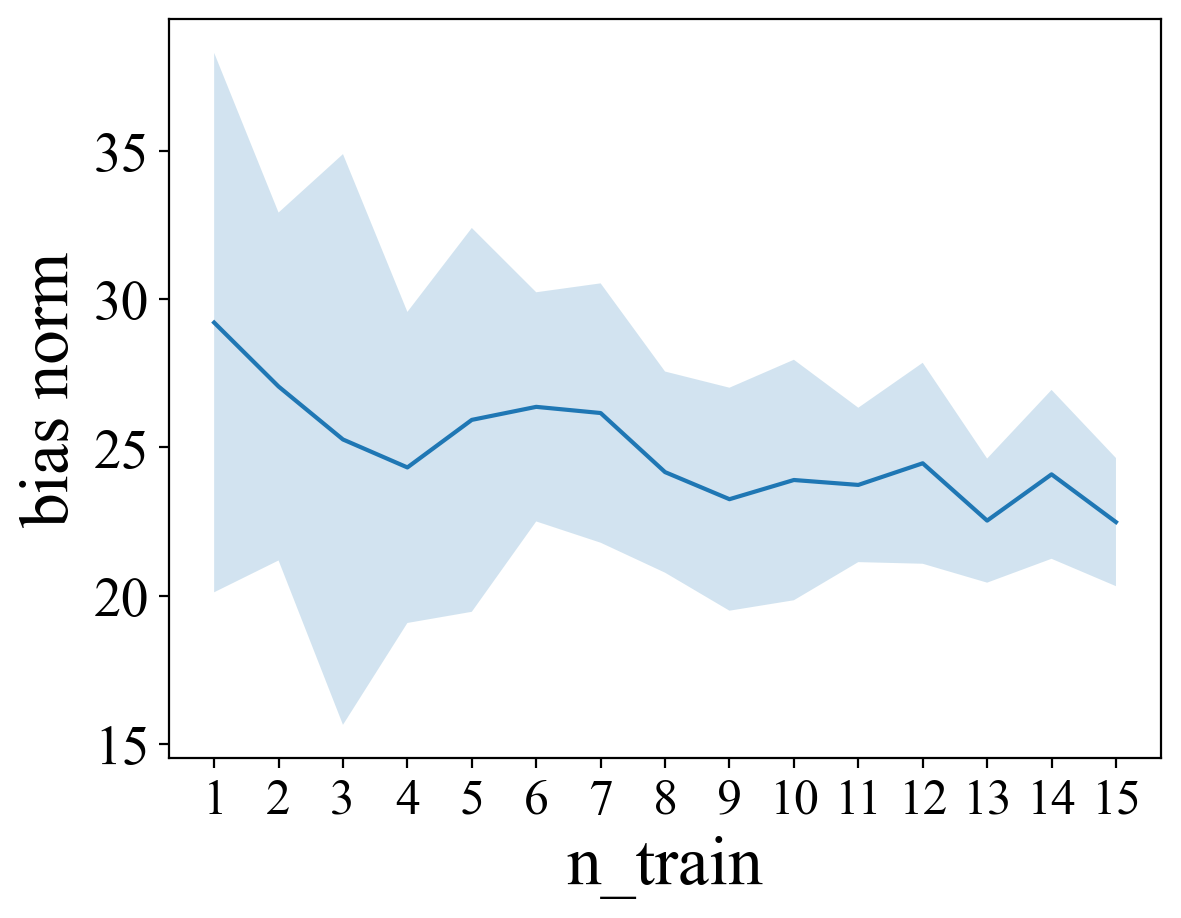

In [33]:
plt.rcdefaults()
#####################################################################################
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE+5)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
#####################################################################################

plt.plot(train_options, means)
plt.fill_between(train_options, means - stds, means + stds, alpha=0.2)
# plt.ylim(bottom = 270)
plt.xticks(train_options)
plt.xlabel("n_train")
plt.ylabel("bias norm")